In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:

import os
import sys
sys.path.append(f"{os.getcwd()}/../src")
import adv

In [4]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:3


## Load in the dataset + classifier

In [5]:
ds = adv.ZJetsDataset(device=device, use_cache=True, dir="../data/adv")

n_train = int(0.8*len(ds))
n_val = len(ds)-n_train

ds_train, ds_val = torch.utils.data.random_split(ds, (n_train, n_val))

x_train, y_train = ds_train[:]
x_val, y_val = ds_val[:]

In [6]:
# note: need to alias JetClassifier from the adv module, since it was in global scope in our last notebook.
JetClassifier = adv.JetClassifier
model = torch.load('../data/adv/classifier1.pt', map_location=device)

In [7]:
npred = 2048 # reduce if you're out of GPU memory
with torch.no_grad():
    model.eval()
    pred_val = torch.softmax(model(x_val[:npred]), axis=-1)[:,1].cpu().numpy()

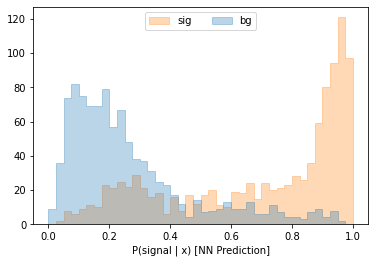

In [8]:
plt.hist([pred_val[y_val[:npred].cpu()==0], pred_val[y_val[:npred].cpu()==1]],
         histtype='step', bins=40, range=(0,1), fill=True, alpha=0.3, color=['C0','C1'], label=['bg', 'sig']);
plt.xlabel("P(signal | x) [NN Prediction]");
plt.legend(loc='upper center', ncol=2);

## Basic FGSM attack
The FGSM method, originally proposed in [arXiv:1412.6572](https://arxiv.org/abs/1412.6572), is a simple method for generating adversarial examples when the exact structure of the target network (including its weights) is known.
More generally, any such attack is referred to as a "first-order" adversary.

The FGSM method is essentially gradient *ascent*, and mechanically it is very similar to the basic backprop algorithm for training networks.
The main difference is that of course, the derivatives are with respect to the input, and the network is held constant. The other difference is that only the sign (or direction) of the graidents is used, and a fixed-sized step is applied, in order to guarantee that the perturbation remains "small".

In [88]:
def fgsm_attack(model, x, y, epsilon=1e-1):
    xadv = x.clone()
    
    # note: these tensors are views into the original x object.
    xpt, xeta, xphi = torch.chunk(xadv, 3, axis=-1)
    
    # mask to suppress "missing" particles.
    mask = xpt>0
    
    # calculate the gradient of the model w.r.t. the *input* tensor:
    
    # first we tell torch that x should be included in grad computations
    xadv.requires_grad = True
    
    # then we just do the forward and backwards pass as usual:
    preds = model(xadv)
    loss = model.loss_fn(preds, y).mean()
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        # now we obtain the gradient of the input.
        # it has the same dimensions as the tensor xadv, and it "points"
        # in the direction of increasing loss values.
        dx = torch.sign(xadv.grad.detach())
        
        # so, we take a step in that direction!
        # However, in our problem, we have to take special care.
        # it makes sense to perturb eta and phi additively, but that doesn't
        # really work so well for pT.
        # Since the dynamic range of the pT variable is so huge, there's
        # no sensible choice of "step size". Instead, we should take a
        # "geometric" (i.e. multiplicative) step, rather than an arithmetic one.
        
        # first, split up the momentum coordinates so we can handle pT as a special case:
        dpt, deta, dphi = torch.chunk(dx, 3, axis=-1)
        
        # similarly for the xadv variable:
        xpt, xeta, xphi = torch.chunk(xadv, 3, axis=-1)
        
        # now, we make the necessary modifications *in-place*, so that
        # we are actually updating the xadv tensor behind the scenes.
        
        # pT is scaled up or down a fraction corresponding to the epsilon size:
        xpt *= (1 - epsilon*torch.sign(dpt))
        
        # each eta and phi takes a fixed size step (epsilon) in the direction (sign) of their gradient
        # we also mask out any changes to "missing" particles:
        xeta += epsilon*torch.sign(deta)*mask
        xphi += epsilon*torch.sign(dphi)*mask
        
        # now xadv contains the perturbed values; we can return it!
        return xadv.detach()

## Execute the attack
We apply the attack on a small subset of events (since it can take a lot of memory).
You could perturb the whole dataset if you broke it into batches, though!

In [89]:
n_attack = 2048

epsilon = 1e-1

x_test = x_val[:n_attack]
y_test = y_val[:n_attack]

x_adv = fgsm_attack(model, x_test, y_test, epsilon=1e-1)
print(x_adv.shape)

torch.Size([2048, 64, 3])


As a sanity check, let's make sure that the changes are indeed within size epsilon. We'll just check eta and phi:

In [90]:
(x_adv[:,:,1:] - x_test[:,:,1:]).abs().max()

tensor(0.1000, device='cuda:2')

## Results
The first thing to look at is the effect the attack had on classifier scores, and metrics such as the accuracy:

In [91]:
with torch.no_grad():
    pred_adv = torch.softmax(model(x_adv), axis=-1)[:,1].cpu().numpy()

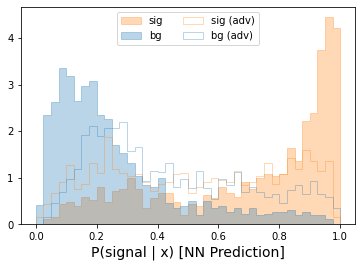

In [92]:
plt.hist([pred_val[y_val[:npred].cpu()==0], pred_val[y_val[:npred].cpu()==1]],
         histtype='step', bins=40, range=(0,1), fill=True, alpha=0.3, color=['C0','C1'], label=['bg', 'sig'], density=True);

plt.hist([pred_adv[y_test.cpu()==0], pred_adv[y_test.cpu()==1]],
         histtype='step', bins=40, range=(0,1), alpha=0.3, color=['C0','C1'], label=['bg (adv)', 'sig (adv)'], density=True);

plt.xlabel("P(signal | x) [NN Prediction]");
plt.legend(loc='upper center', ncol=2);

In [93]:
acc_before = np.mean((pred_val>0.5)==y_val[:npred].cpu().numpy())
acc_after = np.mean((pred_adv>0.5)==y_test.cpu().numpy())

print("Accuracy before: %.3f" % acc_before)
print("Accuracy after:  %.3f" % acc_after)

Accuracy before: 0.808
Accuracy after:  0.574


### Next we can visualize the changes made by the adversary:
The top row shows jets and their classifier scores, before the adversarial perturbation. The bottom row show the same jets after.

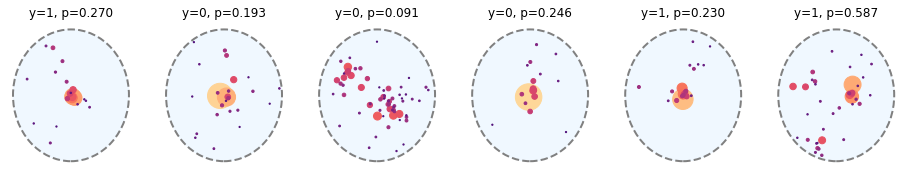

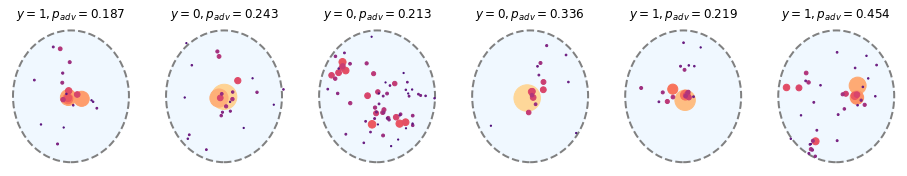

In [94]:
nshow = 6

plt.figure(figsize=plt.figaspect(1/nshow))

offset = 10

for i in range(nshow):
    j0 = adv.center(x_test[i+offset][x_test[i+offset,:,0]>0]).cpu().numpy()
    plt.subplot(1, nshow, i + 1)
    plt.gca().add_artist(plt.Circle((0,0),1,color='aliceblue'))
    plt.gca().add_artist(plt.Circle((0,0),1,ls='--',lw=2,color='gray',fill=False))
    plt.scatter(j0[:,1], j0[:,2], s=(j0[:,0]*3e3)**1., cmap='magma', c=np.log(j0[:,0]), vmin=np.log(5e-5), vmax=np.log(0.5),zorder=2)
    plt.gca().axis('off')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.title("y=%d, p=%.3f" % (y_test[i+offset], pred_val[i+offset]))

plt.figure(figsize=plt.figaspect(1/nshow))
for i in range(nshow):
    j0 = adv.center(x_adv[i+offset][x_adv[i+offset,:,0]>0]).cpu().numpy()
    plt.subplot(1, nshow, i + 1)
    plt.gca().add_artist(plt.Circle((0,0),1,color='aliceblue'))
    plt.gca().add_artist(plt.Circle((0,0),1,ls='--',lw=2,color='gray',fill=False))
    plt.scatter(j0[:,1], j0[:,2], s=(j0[:,0]*3e3)**1., cmap='magma', c=np.log(j0[:,0]), vmin=np.log(5e-5), vmax=np.log(0.5),zorder=2)
    plt.gca().axis('off')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.title(r"$y=%d, p_{adv}=%.3f$" % (y_test[i+offset], pred_adv[i+offset]))

## Iterating: PGD
Clearly our adversary did some damage, but we can refine the results further. The question of interest will be "what is the *worst possible* adversarial example, within a given perturbation limit?".

Obviously, since we are working with hig-dimensional inputs, it is impossible to answer this question directly. Instead, we will try to approximate the global maximum in a manner very similar to how we search for global minima when training networks.

We can basically apply the FGSM iteratively, in a procedure called "projected gradient descent".
The PGD algorithm we will use in the next section is more sophisticated, and we probably don't have time to go over it.

The most important change is that when iterating over perturbations, it is important to constrain the outcomes so that they do not diverge too far from our starting point (i.e., they should stay within an epsilon-ball of our original data).

But we can get a sense for how this works with some fun visualizations! Let's just apply our FGSM method several times in series, and make a video of how the jet changes.

In [111]:
n_steps = 32
epsilon = 0.01 # try using a smaller epsilon since we'll take more steps

x_adv = x_test

# keep a record (in numpy arrays) of the adversarial examples for each step,
# starting with the original unperturbed data.
with torch.no_grad():
    adv_steps = [adv.center(x_adv).cpu().numpy()]
    pred_steps = [torch.softmax(model(x_adv), axis=-1)[:,1].cpu().numpy()]

for i in range(n_steps):
    x_adv = fgsm_attack(model, x_adv, y_test, epsilon=epsilon)
    adv_steps.append(adv.center(x_adv).cpu().numpy())
    with torch.no_grad():
        pred_steps.append(torch.softmax(model(x_adv), axis=-1)[:,1].cpu().numpy())
        pred_adv = torch.softmax(model(x_adv), axis=-1)[:,1].cpu().numpy()
        
adv_steps = np.stack(adv_steps, axis=1)
pred_steps = np.stack(pred_steps, axis=1)

In [112]:
ishow = 0
HTML(adv.animate_jet(adv_steps[ishow], pred_steps[ishow], y_test[ishow]))

In [113]:
ishow = 1
HTML(adv.animate_jet(adv_steps[ishow], pred_steps[ishow], y_test[ishow]))

We can maybe get the sense that the adversary is taking Z-jets with isoated prongs of energy, and merging them closer together, or visa-versa for QCD jets, in order to fool the classifier.
In some way, this gives us some visual insight into what the network has learned during its classification task!

This is also very apparent if we look at the jet-level kinematics before and after the perturbation!

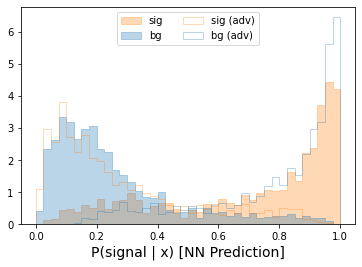

In [115]:
plt.hist([pred_val[y_val[:npred].cpu()==0], pred_val[y_val[:npred].cpu()==1]],
         histtype='step', bins=40, range=(0,1), fill=True, alpha=0.3, color=['C0','C1'], label=['bg', 'sig'], density=True);

plt.hist([pred_adv[y_test.cpu()==0], pred_adv[y_test.cpu()==1]],
         histtype='step', bins=40, range=(0,1), alpha=0.3, color=['C0','C1'], label=['bg (adv)', 'sig (adv)'], density=True);

plt.xlabel("P(signal | x) [NN Prediction]");
plt.legend(loc='upper center', ncol=2);

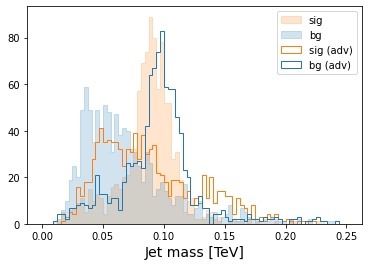

In [114]:
# convert particles to jets
j_test = adv.to_jet(x_test).cpu().numpy()
j_adv = adv.to_jet(x_adv).cpu().numpy()

plt.hist([j_test[y_test.cpu()==0,3], j_test[y_test.cpu()==1,3]], histtype='step', bins=80, range=(0,0.25), fill=True, alpha=0.2, color=['C0','C1'], label=['bg','sig']);
plt.hist([j_adv[y_test.cpu()==0,3], j_adv[y_test.cpu()==1,3]], histtype='step', bins=80, range=(0,0.25), color=['C0','C1'], label=['bg (adv)','sig (adv)']);
plt.xlabel("Jet mass [TeV]")
plt.legend();

## Conclusion
These examples are far from "worst case" scenarios. We are interested in finding the most pernicious, yet subtle attack surfaces, and understanding how well our networks are exposed to them. These kinds of subtlies could, for instance, arise due to differences in MC simulation and real data.

Moreover, we'd like to design networks that are inherently robust against such mismodellings; we will see one method for doing this in the next section.